## Further text preprocessing

### Objectives of this test

- Implement Latent Dirichlet Allocation (**LDA**) from **Gensim** package along with the Mallet’s implementation (via Gensim). 

- Implement **Mallet** that optimizes LDA. Mallet is known to run faster and gives better topic segregation.

- Also extract the volume and percentage contribution of each topic to get **an idea of how important a topic is**.

### Pre-requisites: Downloading NLTK Dutch stopwords, data handling tools, model preprocessing & plotting tools, and SpaCy model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# NLTK
import nltk
nltk.download('stopwords', 'dutch')

[nltk_data] Downloading package stopwords to dutch...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Python data analysis tools and python module for printing
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [5]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [6]:
# SpaCy for lemmatization
import spacy

In [ ]:
# Plotting tools
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt

In [8]:
# Ignoring warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

### Preparing stopwords

In [ ]:
# NLTK Stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words('dutch')

## Loading 628 articles into a list

In [10]:
# Importing file handling library
import os

data = []
path = 'drive/MyDrive/clean_texts/'
for name in os.listdir(path)[:628]:
    with open(path+name, 'r') as file:
        data.append(file.read())


### Tokenizing words and cleaning-up text

In [11]:
# Tokenizing each sentence into a list of words, removing punctuations and unnecessary characters altogether.
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

#print(data_words)

### Creating bigrams and trigrams

**Bigrams** are two (2) words frequently occurring together in the document. **Trigrams** are three (3) words frequently occurring.

In [ ]:
# Building the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Seeing trigram example
#print(trigram_mod[bigram_mod[data_words]])

###  Removing stopwords, making bigrams & trigtrams, and lemmatizing

In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

empty_words = [
    'advies',
    'algemeen',
    'art',
    'artikel',
    'bedoelen',
    'bepalen',
    'bepaling',
    'besluit',
    'betreffen',
    'bevoegd',
    'deel',
    'drie',
    'een',
    'één',
    'gegeven',
    'gelet',
    'geven',
    'goed',
    'hoofdstuk',
    'inlichting',
    'lid',
    'leten',
    'maatregel',
    'minister',
    'naam',
    'nemen',
    'ontwerp',
    'overwegen',
    'overwegende',
    'paragraaf',
    'persoon',
    'toepassing',
    'twee',
    'volgen',
    'voorzien',
    'wet'
] 
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if (token.pos_ in allowed_postags) and (token.lemma_ not in  empty_words )])
    return texts_out

### Initializing SpaCy's Dutch NLP model (small size)

In [ ]:
 !pip install -U spacy
 !python -m spacy download nl_core_news_sm

### Calling the functions in order

In [14]:
 # Removing Stop Words
data_words_nostops = remove_stopwords(data_words)

# Forming Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Loading the SpaCy 'nl' model, keeping only tagger component (for efficiency)
nlp = spacy.load('nl_core_news_sm', disable=['parser', 'ner'])

# Doing lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized)

### Creating the Dictionary and Corpus needed for Topic Modeling

In [15]:
# Creating Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Creating Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Viewing corpus
#print(corpus)

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, **word id 0 occurs once** in the document. Likewise, **word id 1 occurs once too**, and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary. (From https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

In [16]:
# Passing the id as a key to the dictionary to see what word a given ID corresponds to
id2word[0]

'Kb_wib'

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus]

### Building the topic model

The LDA model shall be built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

In [18]:
# Building LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

###  Viewing the topics in LDA model

You can see the keywords for each topic and the weightage (importance) of each keyword using lda_model.print_topics() as shown next.

In [19]:
# Printing keywords for 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.035*"koninklijk" + 0.022*"elektrisch" + 0.020*"huishoud" + 0.020*"virus" '
  '+ 0.016*"omwille" + 0.014*"wijziging" + 0.014*"procedure" + '
  '0.013*"restaurant" + 0.012*"instelling" + 0.012*"collectieve_belegging"'),
 (1,
  '0.028*"fiscaal" + 0.023*"akkoord" + 0.021*"overeenkomst" + 0.021*"bericht" '
  '+ 0.020*"generaal" + 0.020*"bevoegde_autoriteit" + '
  '0.014*"brussel_fiscaliteit" + 0.014*"administratie" + 0.013*"gewestelijk" + '
  '0.013*"betrekking"'),
 (2,
  '0.022*"vaccinatie" + 0.011*"fase" + 0.011*"vaccin" + 0.008*"jaar" + '
  '0.008*"gefedereerde_entiteiten" + 0.007*"verwerking" + 0.006*"daten" + '
  '0.006*"vaccineren" + 0.005*"vernieuwing" + 0.005*"vaccins"'),
 (3,
  '0.068*"decreet" + 0.047*"regering" + 0.026*"aan_nemen" + 0.019*"president" '
  '+ 0.013*"Waals" + 0.013*"aangelegenheid" + 0.012*"bijzondere_machten" + '
  '0.012*"belgisch_staatsblad" + 0.011*"ervan" + 0.011*"grond_wet"'),
 (4,
  '0.055*"vermelden" + 0.041*"Vlaams" + 0.023*"subsidie" + 0.018*"per

**NOTE**: 

The weights reflect how important a keyword is to that topic.

Looking at these keywords, you can guess what this topic could be.

### Compute Model Perplexity and Coherence Score

**Model perplexity** and **topic coherence** provide a convenient measure to judge how good a given topic model is.

In [20]:
# Computing Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Computing Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.570802430967051

Coherence Score:  0.51751224664593


### Visualizing topic-keywords distribution

In [21]:
# Feeding the model into the pyLDAvis instance
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.125896 -0.102670       1        1  11.745250
19    -0.114045  0.129865       2        1   9.148802
6     -0.064444 -0.133751       3        1   8.619813
18    -0.116247  0.053035       4        1   7.227476
15    -0.000171 -0.072388       5        1   6.333101
12    -0.046896 -0.212909       6        1   5.880337
16    -0.097460  0.104521       7        1   5.649175
14    -0.064725 -0.084774       8        1   5.568328
10    -0.080154  0.075815       9        1   5.225188
13     0.033103 -0.048555      10        1   5.012970
5     -0.080031 -0.006326      11        1   4.903634
4     -0.008422 -0.035145      12        1   4.432681
9     -0.120434  0.149018      13        1   3.857847
11    -0.016201 -0.059506      14        1   3.447936
1      0.122449 -0.111966      15        1   3.037906
2      0.331443 -0.002004      16        1   2.831440
17     0.052074  0.121366      17        1   2.303273
3      0.111633  0.237986      18        1   1.925807
8      0.158841 -0.009403      19        1   1.773506
0      0.125583  0.007790      20        1   1.075532, topic_info=           Term         Freq        Total Category  logprob  loglift
463     decreet  1830.000000  1830.000000  Default  30.0000  30.0000
543    regering  2933.000000  2933.000000  Default  29.0000  29.0000
209  koninklijk  2210.000000  2210.000000  Default  28.0000  28.0000
963       waals  1071.000000  1071.000000  Default  27.0000  27.0000
935   vermelden  1340.000000  1340.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
327    volledig    23.432655   399.385879  Topic20  -5.0510   1.6966
173      gevolg    21.328344   755.899808  Topic20  -5.1451   0.9645
322   vervangen    21.277389  1406.975973  Topic20  -5.1475   0.3408
165     gebruik    20.027347   519.385244  Topic20  -5.2080   1.2768
337  voorwaarde    19.395909   983.408298  Topic20  -5.2400   0.6064

[1323 rows x 6 columns], token_table=       Topic      Freq                      Term
term                                            
5829      13  0.902850                       Bel
60         1  0.154905                  Belgisch
60         2  0.031892                  Belgisch
60         3  0.082009                  Belgisch
60         4  0.063785                  Belgisch
...      ...       ...                       ...
364        5  0.018841               zullen_onze
364        7  0.659439               zullen_onze
364       11  0.144448               zullen_onze
13090     16  0.967387  zusta_ndigen_foderierten
13094     16  0.955754   zustandigen_foderierten

[3594 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 20, 7, 19, 16, 13, 17, 15, 11, 14, 6, 5, 10, 12, 2, 3, 18, 4, 9, 1])

**How to make inferences from pyLDAvis' output:**

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

## Mallet's version of LDA

Up next, we will improve upon this model by using **Mallet’s version of LDA algorithm** and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. 

In [ ]:
# Upgrading Gensim
# Updated to enforce Gensim v3.8 in Colab (the last version to support running topic models via Mallet).
# https://github.com/polsci/colab-gensim-mallet
!pip install --upgrade gensim==3.8

In [ ]:
# Installing Mallet
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [24]:
mallet_path = 'mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [25]:
# Showing Topics
pprint(ldamallet.show_topics(formatted=False))

[(4,
  [('patiënt', 0.023876019933190953),
   ('geneeskundige_verzorging', 0.010295164558348393),
   ('zorg', 0.009857072449482503),
   ('verstrekking', 0.008652319150101308),
   ('arts', 0.008597557636493072),
   ('verstrekkingen', 0.008378511582060127),
   ('koning', 0.00794041947319424),
   ('tijdelijk', 0.007447565850720114),
   ('ziekenhuis', 0.0073380428235036415),
   ('mogelijk', 0.006571381632988336)]),
 (0,
  [('ministerieel', 0.015966659450097422),
   ('verspreiding', 0.015317168218229054),
   ('overheid', 0.015208919679584326),
   ('beperken', 0.01369344013855813),
   ('federaal', 0.012719203290755574),
   ('dringend', 0.012394457674821389),
   ('grond_gebied', 0.010662481056505737),
   ('activiteit', 0.010229486901926824),
   ('blijven', 0.007848019051742802),
   ('situatie', 0.007631521974453345)]),
 (17,
  [('verwerking', 0.017171292402579197),
   ('gegevensbank', 0.014087468460891506),
   ('categorie', 0.009531819456125596),
   ('contact', 0.00897112419400056),
   ('cont

In [26]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.518856755508771


**NOTE:** A *remarkable increase* in **coherence score** from  **0.51751224664593** to **0.518856755508771**.

### Finding the optimal number of topics for LDA

The approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

In [28]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

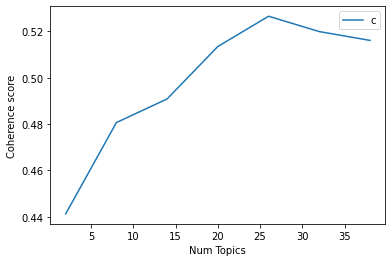

In [29]:
# Showing graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

**NOTE:**
The optimal **coherence score** shown in this plot lies **around 8 number of topics**.

In [30]:
# Printing the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4413
Num Topics = 8  has Coherence Value of 0.4807
Num Topics = 14  has Coherence Value of 0.4909
Num Topics = 20  has Coherence Value of 0.5135
Num Topics = 26  has Coherence Value of 0.5265
Num Topics = 32  has Coherence Value of 0.5199
Num Topics = 38  has Coherence Value of 0.5161


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out.

### Choosing the model with eight (8) topics

In [31]:
# Select the model and print the topics
# The best LDA model with the optimal coherence score has 8 topics, which is
# index 1 from the model_list list
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.012*"verwerking" + 0.008*"categorie" + 0.007*"gegevensbank" + '
  '0.007*"vermelden" + 0.007*"kader" + 0.006*"contact" + 0.006*"betrekking" + '
  '0.005*"digitaal" + 0.005*"verwerken" + 0.005*"federaal"'),
 (1,
  '0.030*"decreet" + 0.023*"vermelden" + 0.018*"Vlaams" + 0.015*"regering" + '
  '0.012*"subsidie" + 0.012*"onderwijs" + 0.010*"afwijking" + 0.010*"periode" '
  '+ 0.009*"aantal" + 0.009*"leerling"'),
 (2,
  '0.009*"raad" + 0.008*"ministerieel" + 0.008*"bevoegdheid" + '
  '0.007*"ontwerpen" + 0.006*"regel" + 0.006*"overheid" + 0.005*"federaal" + '
  '0.005*"geval" + 0.005*"activiteit" + 0.005*"beperken"'),
 (3,
  '0.023*"wet_boek" + 0.016*"woord" + 0.015*"belasting" + 0.015*"vervangen" + '
  '0.010*"bedrag" + 0.010*"betrekking" + 0.010*"hetzelfde" + 0.010*"regeling" '
  '+ 0.009*"fiscaal" + 0.009*"jaar"'),
 (4,
  '0.023*"onderneming" + 0.022*"steun" + 0.015*"regering" + 0.014*"waals" + '
  '0.012*"activiteit" + 0.012*"code" + 0.011*"decreet" + 0.010*"economisch" + '
  

### Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the **topic number that has the highest percentage contribution** in the document/set of documents.

In [32]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_words)

In [33]:
# Formatting
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Showing
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.8185,"wet_boek, woord, belasting, vervangen, bedrag,...","[de, coefficient, bedoeld, in, artikel, van, h..."
1,1,6.0,0.5919,"patiënt, mogelijk, kader, ziekenhuis, volksgez...","[filip, koning, der, belgen, aan, allen, die, ..."
2,2,7.0,0.5014,"koninklijk, periode, sociaal, tijdelijk, zelfs...","[verslag, aan, de, koning, sire, het, koninkli..."
3,3,1.0,0.5558,"decreet, vermelden, Vlaams, regering, subsidie...","[de, regering, van, de, franse, gemeenschap, g..."
4,4,4.0,0.5883,"onderneming, steun, regering, waals, activitei...","[de, waalse, regering, gelet, op, het, decreet..."
5,5,0.0,0.3099,"verwerking, categorie, gegevensbank, vermelden...","[het, vlaams, parlement, heeft, aangenomen, en..."
6,6,3.0,0.2575,"wet_boek, woord, belasting, vervangen, bedrag,...","[in, worden, de, woorden, pct, vervangen, door..."
7,7,4.0,0.3093,"onderneming, steun, regering, waals, activitei...","[de, regering, van, de, franse, gemeenschap, g..."
8,8,5.0,0.3293,"regering, brusselse_hoofdstedelijk, ordonnanti...","[filip, koning, der, belgen, aan, allen, die, ..."
9,9,5.0,0.3973,"regering, brusselse_hoofdstedelijk, ordonnanti...","[de, brusselse, hoofdstedelijke, regering, gel..."


### Finding the most representative document for each topic

With understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [34]:
# Grouping the top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reseting Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Formating
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Showing
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9386,"verwerking, categorie, gegevensbank, vermelden...","[krachtens, artikel, van, het, koninklijk, bes..."
1,1.0,0.8483,"decreet, vermelden, Vlaams, regering, subsidie...","[rechtsgronden, dit, besluit, is, gebaseerd, o..."
2,2.0,0.9573,"raad, ministerieel, bevoegdheid, ontwerpen, re...","[in, het, belgisch, staatsblad, nr, van, zonda..."
3,3.0,0.9799,"wet_boek, woord, belasting, vervangen, bedrag,...","[filip, koning, der, belgen, aan, allen, die, ..."
4,4.0,0.9051,"onderneming, steun, regering, waals, activitei...","[de, minister, van, economie, gelet, op, het, ..."


The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The **Perc_Contribution column** is nothing but the percentage contribution of the topic in the given document.

## Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. 

In [35]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenatinate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,3.0,"wet_boek, woord, belasting, vervangen, bedrag,...",36.0,0.0573
1.0,6.0,"patiënt, mogelijk, kader, ziekenhuis, volksgez...",90.0,0.1433
2.0,7.0,"koninklijk, periode, sociaal, tijdelijk, zelfs...",35.0,0.0557
3.0,1.0,"decreet, vermelden, Vlaams, regering, subsidie...",87.0,0.1385
4.0,4.0,"onderneming, steun, regering, waals, activitei...",84.0,0.1338
...,...,...,...,...
623.0,6.0,"patiënt, mogelijk, kader, ziekenhuis, volksgez...",NaN,NaN
624.0,5.0,"regering, brusselse_hoofdstedelijk, ordonnanti...",NaN,NaN
625.0,5.0,"regering, brusselse_hoofdstedelijk, ordonnanti...",NaN,NaN
626.0,3.0,"wet_boek, woord, belasting, vervangen, bedrag,...",NaN,NaN


## CONCLUSION

From ten (10) Dutch legal text files that were cleaned, further ML preprocessing and unsupervised topic extraction were carried out via:

- A basic topic model using Gensim’s LDA; 

- pyLDAvis for topic visualisation; and 

- Mallet’s LDA implementation.